### Load example video

In [1]:
from torchvision.io import read_video

In [2]:
video_path = "samples/bwdmzwhdnw.mp4"
video, audio, info = read_video(str(video_path), pts_unit="sec")

In [3]:
info

{'video_fps': 29.97, 'audio_fps': 48000}

In [4]:
video.shape # (T, H, W, C)

torch.Size([300, 1080, 1920, 3])

In [5]:
audio.shape # (C, T)

torch.Size([1, 480256])

### Load preprocessors

In [7]:
from utils import ImagePreprocessor, AudioPreprocessor

In [8]:
img_processor = ImagePreprocessor(window_len=-1)
img_tensor = img_processor(video, info.get("video_fps", 30.0))
img_tensor.shape # (N, C, H, W)

torch.Size([1, 3, 112, 112])

In [9]:
aud_processor = AudioPreprocessor(window_len=-1)
aud_tensor = aud_processor(audio, info.get("audio_fps", 16_000))
aud_tensor.shape # (N, C, T)

torch.Size([1, 1, 160086])

### Load uni-modal models

In [10]:
from utils import ArcFace, ReDimNet
import torch

In [11]:
img_model = ArcFace()
img_model.eval();
aud_model = ReDimNet()
aud_model.eval();

d:\PNW\SynthWeave\venv\Lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


d:\PNW\SynthWeave\venv\Lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/IDRnD/ReDimNet/zipball/master" to C:\Users\izam1/.cache\torch\hub\master.zip


C:\Users\izam1/.cache\torch\hub\IDRnD_ReDimNet_master


Downloading: "https://github.com/IDRnD/ReDimNet/releases/download/latest/b6-vox2-ptn.pt" to C:\Users\izam1/.cache\torch\hub\checkpoints\b6-vox2-ptn.pt
100%|██████████| 57.9M/57.9M [00:01<00:00, 49.2MB/s]


load_res : <All keys matched successfully>


In [12]:
with torch.no_grad():
    img_emb = img_model(img_tensor)
img_emb.shape

torch.Size([1, 512])

In [13]:
with torch.no_grad():
    aud_emb = aud_model(aud_tensor)
aud_emb.shape

C:\Users\izam1/.cache\torch\hub\IDRnD_ReDimNet_master\redimnet\layers\features.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


torch.Size([1, 192])

### Load fusion module

In [20]:
# from synthweave.fusion import CFF, AFF, IAFF, CAFF, GFF

# or

from synthweave.utils import get_fusion

In [21]:
FUSION = "CFF"
EMB_DIM = 256

fusion = get_fusion(
    fusion_name=FUSION,
    output_dim=EMB_DIM,
    modality_keys=["image", "audio"],
    out_proj_dim=256,
    
    # num_att_heads=4,
)

# fusion.load_state_dict(torch.load("../../../models/fusion/CFF.pth"))

[INFO] This fusion expects embeddings of shape (batch_size, embed_dim).


### Construct pipeline

In [22]:
from synthweave.pipeline import BasePipeline

In [23]:
pipe = BasePipeline(
    processors={
        "image": img_processor,
        "audio": aud_processor
    },
    models={
        "image": img_model,
        "audio": aud_model
    },
    fusion=fusion,
    head=torch.nn.Sequential(torch.nn.Linear(256, 1), torch.nn.Sigmoid())
)
pipe.eval();

### Run the pipeline

In [24]:
reference_sample = "samples/zfobicuigx.mp4"
fake_sample = "samples/bwdmzwhdnw.mp4"

ref_video, ref_audio, ref_info = read_video(str(reference_sample), pts_unit="sec")
fake_video, fake_audio, fake_info = read_video(str(fake_sample), pts_unit="sec")

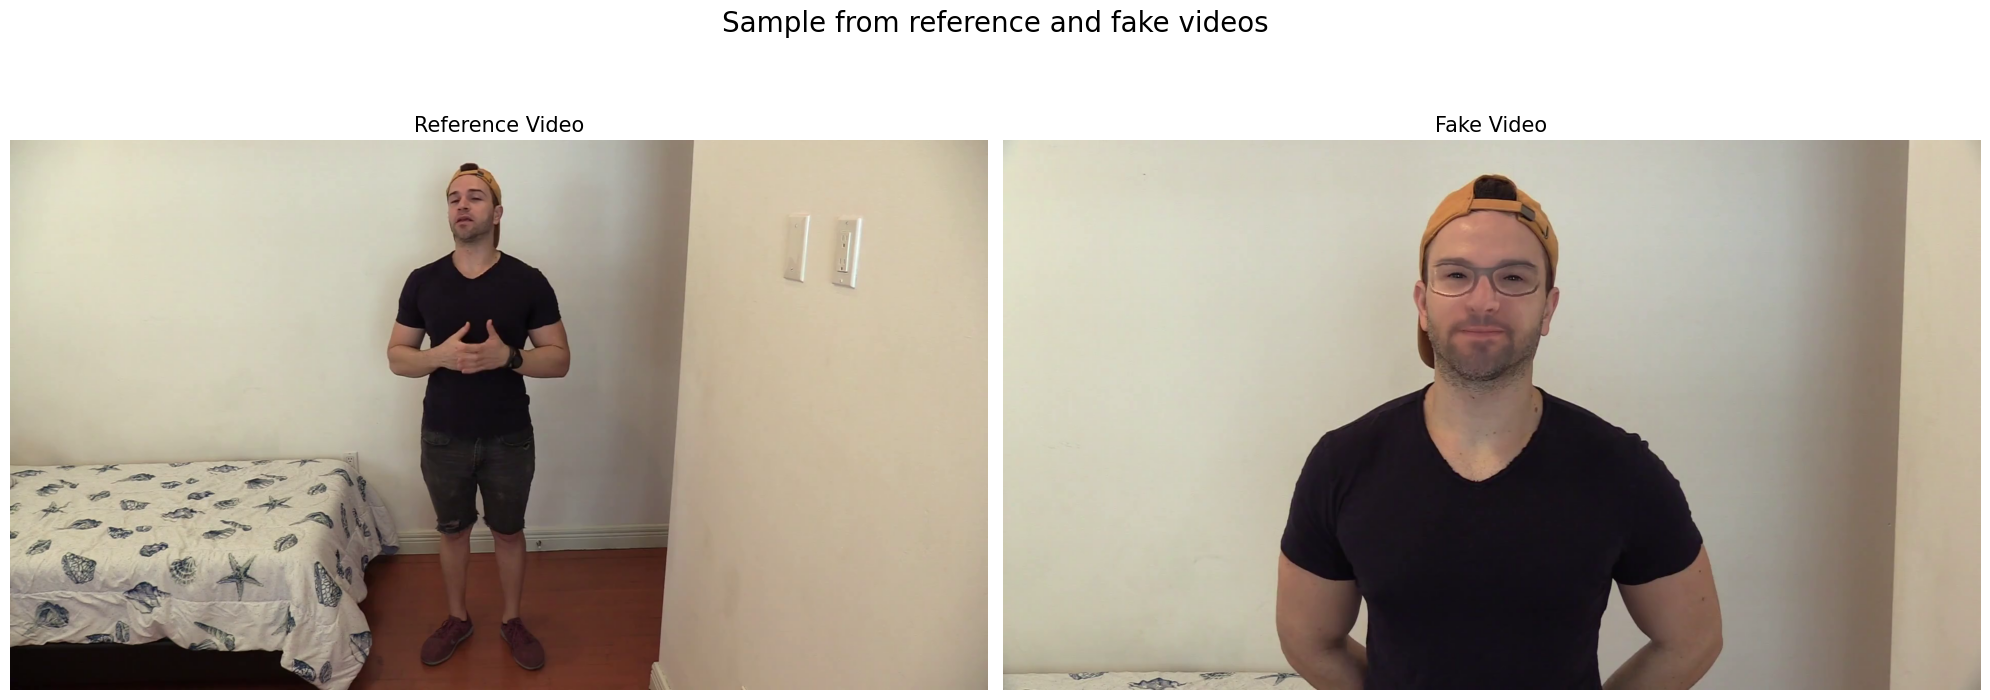

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2, figsize=(20, 8))

plt.suptitle("Sample from reference and fake videos", fontsize=20)

axs[0].imshow(ref_video[0])
axs[0].axis("off")
axs[0].set_title("Reference Video", fontsize=15)

axs[1].imshow(fake_video[0])
axs[1].axis("off")
axs[1].set_title("Fake Video", fontsize=15)

plt.tight_layout()
plt.show()

In [26]:
from IPython.display import Audio

print("Reference Audio")
Audio(ref_audio[0].numpy(), rate=ref_info.get("audio_fps", 16_000))
display(Audio(ref_audio[0].numpy(), rate=ref_info.get("audio_fps", 16_000)))

print("Fake Audio")
display(Audio(fake_audio[0].numpy(), rate=fake_info.get("audio_fps", 16_000)))

Reference Audio


Fake Audio


In [27]:
ref_inputs = {
    "image": (ref_video, ref_info.get("video_fps", 30.0)),
    "audio": (ref_audio, ref_info.get("audio_fps", 16_000))
}

fake_inputs = {
    "image": (fake_video, fake_info.get("video_fps", 30.0)),
    "audio": (fake_audio, fake_info.get("audio_fps", 16_000))
}

with torch.no_grad():
    ref_output = pipe.forward(ref_inputs, output_feats=True)
    fake_output = pipe.forward(fake_inputs, output_feats=True)

C:\Users\izam1/.cache\torch\hub\IDRnD_ReDimNet_master\redimnet\layers\features.py:137: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [28]:
ref_output_img = ref_output["image"][0]
fake_output_img = fake_output["image"][0]

img_sim = img_model.compute_similarities(ref_output_img, fake_output_img)

print(f"Face Similarity: {img_sim:.2f}%")

Face Similarity: 99.91%


d:\PNW\SynthWeave\examples\deepfake_detection\utils.py:106: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3729.)
  return np.dot(e_i, e_j.T) / (np.linalg.norm(e_i) * np.linalg.norm(e_j)) * 100


In [29]:
ref_output_aud = ref_output["audio"][0]
fake_output_aud = fake_output["audio"][0]

aud_sim = aud_model.compute_similarities(ref_output_aud, fake_output_aud)

print(f"Voice Similarity: {aud_sim:.2f}%")

Voice Similarity: 8.18%


In [30]:
print(f"Fake Probability: {fake_output["logits"].item()*100:.2f}%")

Fake Probability: 48.91%
